# Hand Detection

Computer Vision project UniPD, 2022.

Group: Grotto Gionata, Mosco Simone, Pisacreta Giulia.

Packages required

In [1]:
import os
import cv2
import scipy.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#mat files
!pip install mat4py
from mat4py import loadmat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download Dataset

The dataset (https://www.robots.ox.ac.uk/~vgg/data/hands/) wiil be placed in the *dataset* folder and it has the following structure:

dataset
- training_dataset
  * training_data
    - annotations
    - images
- test_dataset
  * test_data
    - annotations
    - images
- validation_dataset
  * validation_data
    - annotations
    - images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#create folder
!mkdir /content/dataset

#unzip into new folder folder
!tar -xzvf '/content/drive/MyDrive/hand_dataset.tar.gz' -C '/content/dataset'

### Import Dataset

Import the three Train, Test and Validation dataset

In [3]:
#function to load a dataset from its directory
def load_dataset(path):
  data = []
  images_path = os.path.join(path, 'images')
  annotations_path = os.path.join(path, 'annotations')

  for img_name in os.listdir(images_path):
    ann_name = img_name[:-3] + 'mat'
    try:
      #get image
      img = cv2.imread(os.path.join(images_path, img_name))
      #convert to rgb
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #TODO: resize image (?)

      #get annotations and convert it
      boxes = loadmat(os.path.join(annotations_path, ann_name))['boxes']
      if type(boxes) == list:
        annotations = [list(box.values())[:4] for box in boxes]
      elif type(boxes) == dict:
        annotations = list(boxes.values())[:4]
      data.append([img, annotations])
    except Exception as e:
      print(e)
  return np.array(data)


#path of the datasets
data_dir = Path('/content/dataset/hand_dataset')
train_dir = os.path.join(data_dir, 'training_dataset/training_data')
val_dir = os.path.join(data_dir, 'validation_dataset/validation_data')
test_dir = os.path.join(data_dir, 'test_dataset/test_data')

train_dataset = load_dataset(train_dir)
val_dataset = load_dataset(val_dir)
test_dataset = load_dataset(test_dir)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Visualize a sample and its annotations

In [4]:
print('Annotations: ')
print(train_dataset[0][1])

Annotations: 
[[432.4696414195462, 255.7352770848963], [410.2503585804542, 272.9047229151038], [445.61035858045415, 318.66472291510377], [467.8296414195462, 301.4952770848963]]


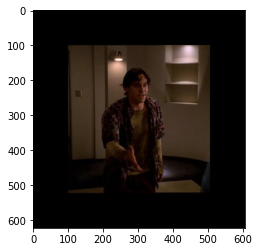

In [5]:
plt.imshow(train_dataset[0][0])

In order to obtain bounding boxes with only vertical and horizontal lines, we transform the default ones into the following format:

    [x top left corner, y top left corner, width, height]

In [6]:
def convert_bbox(values):
  #values is a list of points as [[y1, x1], [y2, x2], [y3, x3], [y4, x4]]
  
  x_min = int(min([point[1] for point in values]))
  y_min = int(min([point[0] for point in values]))
  width = int(max([point[1] for point in values]) - x_min)
  height = int(max([point[0] for point in values]) - y_min)

  return [x_min, y_min, width, height]

In [7]:
def convert_dataset(dataset):
  new_dataset = []
  for sample in dataset:
    #case with only a hand in the image
    if len(sample[1][0]) == 2:
      boxes = convert_bbox(sample[1])
    else:
      boxes = [convert_bbox(box) for box in sample[1]]
    new_dataset.append([sample[0], boxes])

  return np.array(new_dataset)

In [45]:
train_set = convert_dataset(train_dataset)
val_set = convert_dataset(val_dataset)
test_set = convert_dataset(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


Display a sample image with the custom bounding boxes

In [9]:
def draw_boxes(img, boxes):
  image = img.copy()
  color = (0, 255, 0)
  #case where only a hand is present in the image
  if isinstance(boxes[0], int):
    point1 = (boxes[0], boxes[1])
    point2 = (boxes[0]+boxes[2], boxes[1]+boxes[3])
    image = cv2.rectangle(image, point1, point2, color, 2)
  else:
    for box in boxes:
      point1 = (box[0], box[1])
      point2 = (box[0]+box[2], box[1]+box[3])
      image = cv2.rectangle(image, point1, point2, color, 2)

  plt.imshow(image)

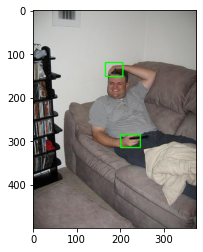

In [15]:
sample_num = 5
draw_boxes(train_set[sample_num][0], train_set[sample_num][1])

**Dataset Structure**

    dataset[0] = image and annotations
    dataset[0][0] = iamge
    dataset[0][1] = annotations

### Preprocessing

All the images must be resized to a fixed size, in this case $256\times256$. Regarding the labels, they must be in the format

    class x_center y_center width height

where the attribute class is the same for all the image and equal to zero, while the other property must be normalized with values between 0 and 1.

In [12]:
img_size = 256

In [59]:
def set_labels(box, old_shape):
  x_center = (box[0]*2 + box[2])/(2*old_shape[1])
  y_center = (box[1]*2 + box[3])/(2*old_shape[0])
  width = box[2]/old_shape[1]
  height = box[3]/old_shape[0]

  return [x_center, y_center, width, height]

In [35]:
def prepare_dataset(dataset):
  data = []
  for sample in dataset:
    shape = sample[0].shape
    #resize image to a img_size
    res_image = cv2.resize(sample[0], (img_size, img_size))
    #modify the labels
    if isinstance(sample[1][0], int):
      labels = set_labels(sample[1], shape)
    else:
      labels = [set_labels(box, shape) for box in sample[1]]
    data.append([res_image, labels])

  return np.array(data)

In [60]:
train_data = prepare_dataset(train_set)
val_data = prepare_dataset(val_set)
test_data = prepare_dataset(test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Visualize and print labels of a sample

ORIGINAL IMAGE
Labels:  [[15, 135, 97, 96], [134, 51, 93, 100]]


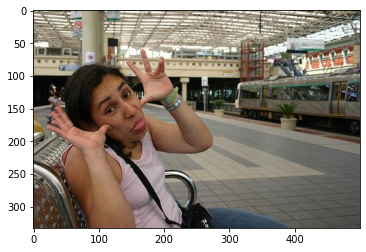

In [63]:
print('ORIGINAL IMAGE')
print('Labels: ', train_set[1010][1])
plt.imshow(train_set[1010][0])

RESIZED IMAGE
Labels:  [[0.127, 0.5495495495495496, 0.194, 0.2882882882882883], [0.361, 0.3033033033033033, 0.186, 0.3003003003003003]]


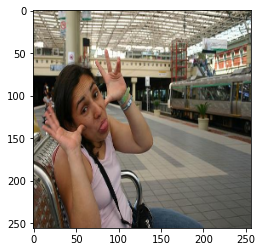

In [64]:
print('RESIZED IMAGE')
print('Labels: ', train_data[1010][1])
plt.imshow(train_data[1010][0])

Save the new dataset, containing resized image and normalized coordinates in specific folders

In [65]:
#TODO: save final datasets

### Training with **YOLOv5**

Install YOLOv5 and requirements

In [11]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12589, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12589 (delta 6), reused 8 (delta 3), pack-reused 12575
Receiving objects: 100% (12589/12589), 12.26 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (8663/8663), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.2 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.11.0 which is incompatible.
     |████████████████████████████████| 4.3 MB 5.4 MB/s 
     |████████████████████████████████| 21.6 MB 2